# **LSTM**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

In [3]:
plt.rcParams['figure.figsize'] = (10,5)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## **OBTENDO OS DADOS**

In [5]:
company = 'GOOG'
df = GOOG[:int(len(GOOG)*.7)]
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)

print(df.shape)
df.head()

(1503, 5)


,open,high,low,close,volume
2004-08-19,100.00,104.06,95.96,100.34,22351900
2004-08-20,101.01,109.08,100.50,108.31,11428600
2004-08-23,110.75,113.48,109.05,109.40,9137200
2004-08-24,111.24,111.60,103.57,104.87,7631300
2004-08-25,104.96,108.00,103.88,106.00,4598900


In [6]:
df_test = GOOG[int(len(GOOG)*.7):]
df_test.rename(columns={col: col.lower() for col in df_test.columns}, inplace=True)

actual_prices = df_test['close'].values
total_dataset = pd.concat((df['close'], df_test['close']), axis=0)

## **PREPARAÇÃO DOS DADOS**

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1,1))

In [8]:
prediction_days = 80

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])

In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## **CRIANDO O MODELO**

In [11]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
45/45 [==============================] - 10s 94ms/step - loss: 0.0289
Epoch 2/25
45/45 [==============================] - 4s 94ms/step - loss: 0.0060
Epoch 3/25
45/45 [==============================] - 4s 90ms/step - loss: 0.0049
Epoch 4/25
45/45 [==============================] - 4s 93ms/step - loss: 0.0046
Epoch 5/25
45/45 [==============================] - 4s 92ms/step - loss: 0.0043
Epoch 6/25
45/45 [==============================] - 4s 93ms/step - loss: 0.0038
Epoch 7/25
45/45 [==============================] - 4s 91ms/step - loss: 0.0040
Epoch 8/25
45/45 [==============================] - 4s 93ms/step - loss: 0.0038
Epoch 9/25
45/45 [==============================] - 4s 96ms/step - loss: 0.0033
Epoch 10/25
45/45 [==============================] - 4s 92ms/step - loss: 0.0037
Epoch 11/25
45/45 [==============================] - 4s 92ms/step - loss: 0.0030
Epoch 12/25
45/45 [==============================] - 4s 90ms/step - loss: 0.0030
Epoch 13/25
45/45 [=================

In [12]:
model_inputs= total_dataset[len(total_dataset) - len(df_test) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [13]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days: x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

21/21 [==============================] - 2s 31ms/step


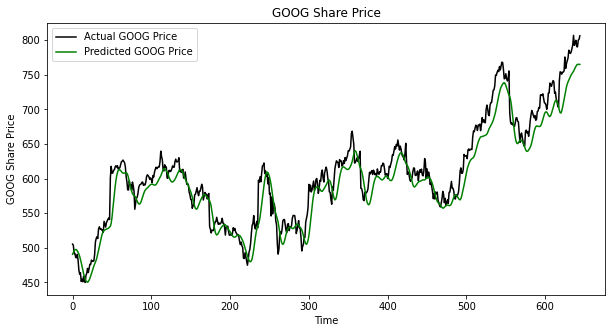

In [14]:
plt.plot(actual_prices, color='black', label= f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label= f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend([f'Actual {company} Price', f'Predicted {company} Price'])
plt.show()

In [15]:
print(mean_squared_error(actual_prices, predicted_prices))
print(r2_score(actual_prices, predicted_prices))

553.9064521112933
0.8977925985399722
